In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


<ipython-input-3-4b1b9c6da0a4>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


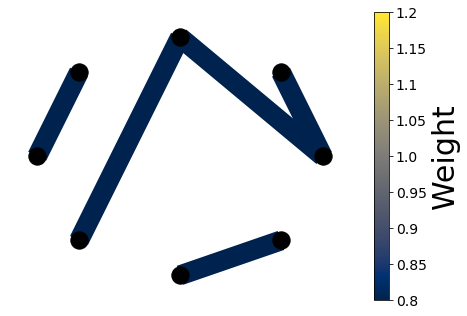

In [3]:
import networkx as nx
import numpy as np
from networkx.algorithms.approximation.vertex_cover import min_weighted_vertex_cover
import matplotlib.pyplot as plt
np.random.seed(1)
n = 10
m = int(n/2)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
weights = {edge:1 for edge in edges}

G=nx.Graph()
G.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])
pos=nx.circular_layout(G)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in G.edges]
widths = [int(10+10*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in G.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(G, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [4]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx
max_gamma = 2 * np.pi
max_beta = np.pi

def expectation_objective(graph):
    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circuit_gen.circ_qaoa(weights, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in weights.items()
        ]
            
        return sum(ens).real
    return gamma_beta_objective, history

/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

In [5]:
import networkx as nx
obj, hist = expectation_objective(G)
all_data = []
bound = np.pi
samples = 10
for g in np.linspace(0, bound, num=samples):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

0.0
0.3490658503988659
0.6981317007977318
1.0471975511965976
1.3962634015954636
1.7453292519943295
2.0943951023931953
2.443460952792061
2.792526803190927
3.141592653589793


In [6]:
np.max(all_data)

3.2463630200123257

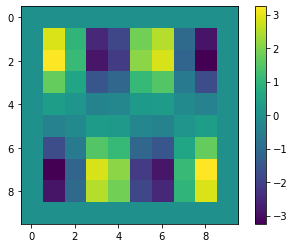

In [7]:
import matplotlib.pyplot as plt
import pickle as pkl

plt.imshow(np.array(all_data))
plt.colorbar()
plt.savefig("/home/ampolloreno/landscape.png", dpi=200, bbox_inches='tight')
with open("landscape.pkl", 'wb') as file_:
    file_.write(np.array(all_data))

In [9]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

np.random.seed(666)
reprate = 50 
one_hour = 60 * 60
max_gamma = 2 * np.pi
max_beta = np.pi

def objective(graph):
    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p = 1
        gammas = [gamma_beta[1]/np.pi]
        betas = [gamma_beta[0]/np.pi]
        circ_ex = qtn.circuit_gen.circ_qaoa(weights, p, gammas, betas)
        circ_ex.sample_rehearse(optimize=opt)
        samples = list(circ_ex.sample(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in weights.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history



# Evolution Strategies

In [10]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [11]:
from tqdm import tqdm
shots_per_point = 10
MAX_ITERATION = 10
fit_func1, history = objective(G)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [12]:
history, result = test_solver(oes)

 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

(array([ 0.25155249, -0.30883551]), 3.3, 3.3, 0.39269908169872414)


 20%|██        | 2/10 [00:02<00:08,  1.10s/it]

(array([ 0.4647593 , -0.97973381]), 2.9, 2.9, 0.39269908169872414)


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]

(array([ 0.68801043, -0.32234818]), 3.5, 3.5, 0.39269908169872414)


 40%|████      | 4/10 [00:04<00:06,  1.12s/it]

(array([-0.14541657,  0.26039435]), 3.1, 3.1, 0.39269908169872414)


 50%|█████     | 5/10 [00:05<00:05,  1.12s/it]

(array([ 0.59715067, -0.893209  ]), 3.9, 3.9, 0.39269908169872414)


 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

(array([-0.85142011,  0.50016885]), 3.2, 3.2, 0.39269908169872414)


 70%|███████   | 7/10 [00:07<00:03,  1.14s/it]

(array([-0.37253552, -0.14361985]), 3.2, 3.2, 0.39269908169872414)


 80%|████████  | 8/10 [00:09<00:02,  1.12s/it]

(array([-0.38329103,  0.74666219]), 3.2, 3.2, 0.39269908169872414)


 90%|█████████ | 9/10 [00:10<00:01,  1.13s/it]

(array([ 0.89065842, -0.50340714]), 3.4, 3.4, 0.39269908169872414)


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

(array([-0.22416832, -0.10097385]), 3.4, 3.4, 0.39269908169872414)
local optimum discovered by solver:
 [-0.22416832 -0.10097385]
fitness score at this local optimum: 3.4


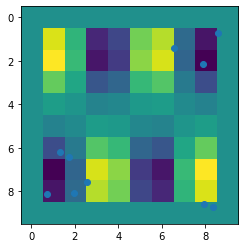

In [13]:
plt.imshow(all_data)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

# An annealing attempt on a graph.

In [14]:
from tqdm import tqdm
annealing_attempts = []
seed = 1
shots_per_point = 1000
func, history2 = objective(G)
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    maxiter=10,
    maxfun=one_hour*reprate,
    seed=seed)
result.fun = -result.fun
(result.x, result.fun)        

KeyboardInterrupt: 

> /home/ampolloreno/repos/quimb/quimb/tensor/circuit.py(633)sample_bitstring_from_prob_ndarray()
    631         '01011'
    632     """
--> 633     b = np.random.choice(np.arange(p.size), p=p.flat)
    634     return f"{b:0>{p.ndim}b}"
    635 

ipdb> c


In [ ]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [el[1]%(bound)*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2)
plt.scatter([result.x[0]%(bound)*(samples-1)/(bound)], [result.x[1]%(bound)*(samples-1)/(bound)])
plt.imshow(all_data)